In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Split Train/test

In [3]:
PBMC = sp.read_h5ad("../pbmc_multiome.h5ad")

In [4]:
data = PBMC.X

In [5]:
print(f"The data has {PBMC.n_obs} observations and {PBMC.n_vars} features.")

The data has 9641 observations and 19607 features.


In [6]:
cutoff = 0.001

cell_types, type_numbers = np.unique(PBMC.obs['predicted.id'], return_counts=True)
bad_types = cell_types[type_numbers / len(PBMC.obs['predicted.id'])<cutoff]
print(bad_types)

bad_types_mask = np.invert(np.isin(PBMC.obs['predicted.id'], bad_types))
X = PBMC.X[bad_types_mask]
Y = PBMC.obs['predicted.id'][bad_types_mask]

print(Y.shape)

['ASDC' 'CD4 Proliferating' 'CD8 Proliferating' 'HSPC' 'ILC' 'cDC1' 'dnT']
(9619,)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)

n_train = X_train.shape[0]
n_test = X_test.shape[0]
print(f"{n_train} train samples\n{n_test} test samples\n{n_train/(n_train+n_test)*100:.2f}% of samples used for training")

7214 train samples
2405 test samples
75.00% of samples used for training


# Model Analysis

In [11]:
# load model
with open('PBMC_lsvm_001_filter.pkl', 'rb') as f:
    best_model = pickle.load(f)

In [12]:
test_pred = best_model.predict(X_test)
train_pred = best_model.predict(X_train)
all_pred = best_model.predict(data)

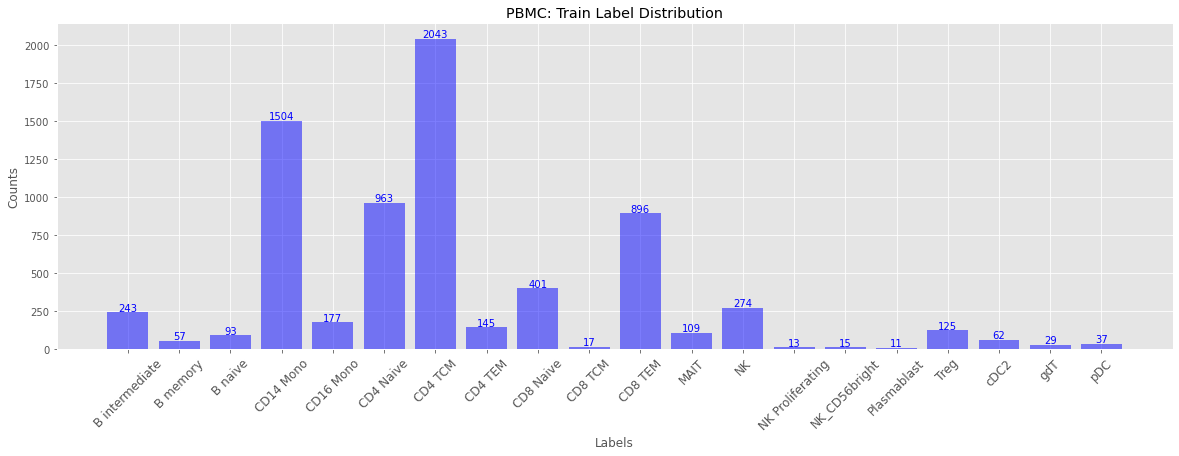

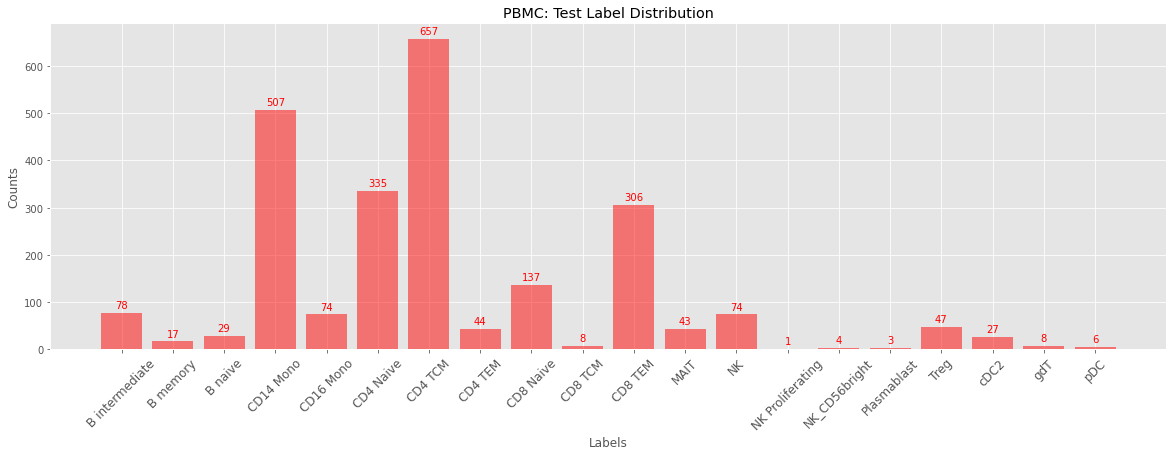

In [22]:
train_label_counts = np.unique(Y_train, return_counts=True)
test_label_counts = np.unique(Y_test, return_counts=True)

# Train Label Distribution
plt.figure(figsize=(20, 6))
plt.bar(train_label_counts[0], train_label_counts[1], color='blue', alpha=0.5)
for i in range(len(train_label_counts[0])):
    plt.text(train_label_counts[0][i], train_label_counts[1][i] + 10, str(train_label_counts[1][i]), ha='center', color='blue')
plt.xlabel('Labels')
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Counts')
plt.title('PBMC: Train Label Distribution')
plt.show()

# Test Label Distribution
plt.figure(figsize=(20, 6))
plt.bar(test_label_counts[0], test_label_counts[1], color='red', alpha=0.5)
for i in range(len(test_label_counts[0])):
    plt.text(test_label_counts[0][i], test_label_counts[1][i] + 10, str(test_label_counts[1][i]), ha='center', color='red')
plt.xlabel('Labels')
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Counts')
plt.title('PBMC: Test Label Distribution')
plt.show()

## Accuracy

In [55]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score


print(f"Train accuracy: {accuracy_score(Y_train, train_pred):.5f}")
print(f"Test accuracy: {accuracy_score(Y_test, test_pred):.5f}")
print("")
print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train, train_pred):.5f}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test, test_pred):.5f}")
print("")

Train accuracy: 0.95661
Test accuracy: 0.94137

Balanced Train Accuracy: 0.91391
Balanced Test Accuracy: 0.81852



## F1 Score

In [56]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, test_pred))

                  precision    recall  f1-score   support

  B intermediate       0.90      0.97      0.94        78
        B memory       1.00      1.00      1.00        17
         B naive       1.00      0.72      0.84        29
       CD14 Mono       0.98      0.99      0.99       507
       CD16 Mono       0.97      0.99      0.98        74
       CD4 Naive       0.92      0.92      0.92       335
         CD4 TCM       0.92      0.94      0.93       657
         CD4 TEM       0.97      0.64      0.77        44
       CD8 Naive       0.98      0.98      0.98       137
         CD8 TCM       1.00      0.75      0.86         8
         CD8 TEM       0.90      0.94      0.92       306
            MAIT       0.95      0.93      0.94        43
              NK       0.91      0.96      0.93        74
NK Proliferating       0.00      0.00      0.00         1
   NK_CD56bright       1.00      0.50      0.67         4
     Plasmablast       1.00      0.67      0.80         3
            T

/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

## Confusion Matrices

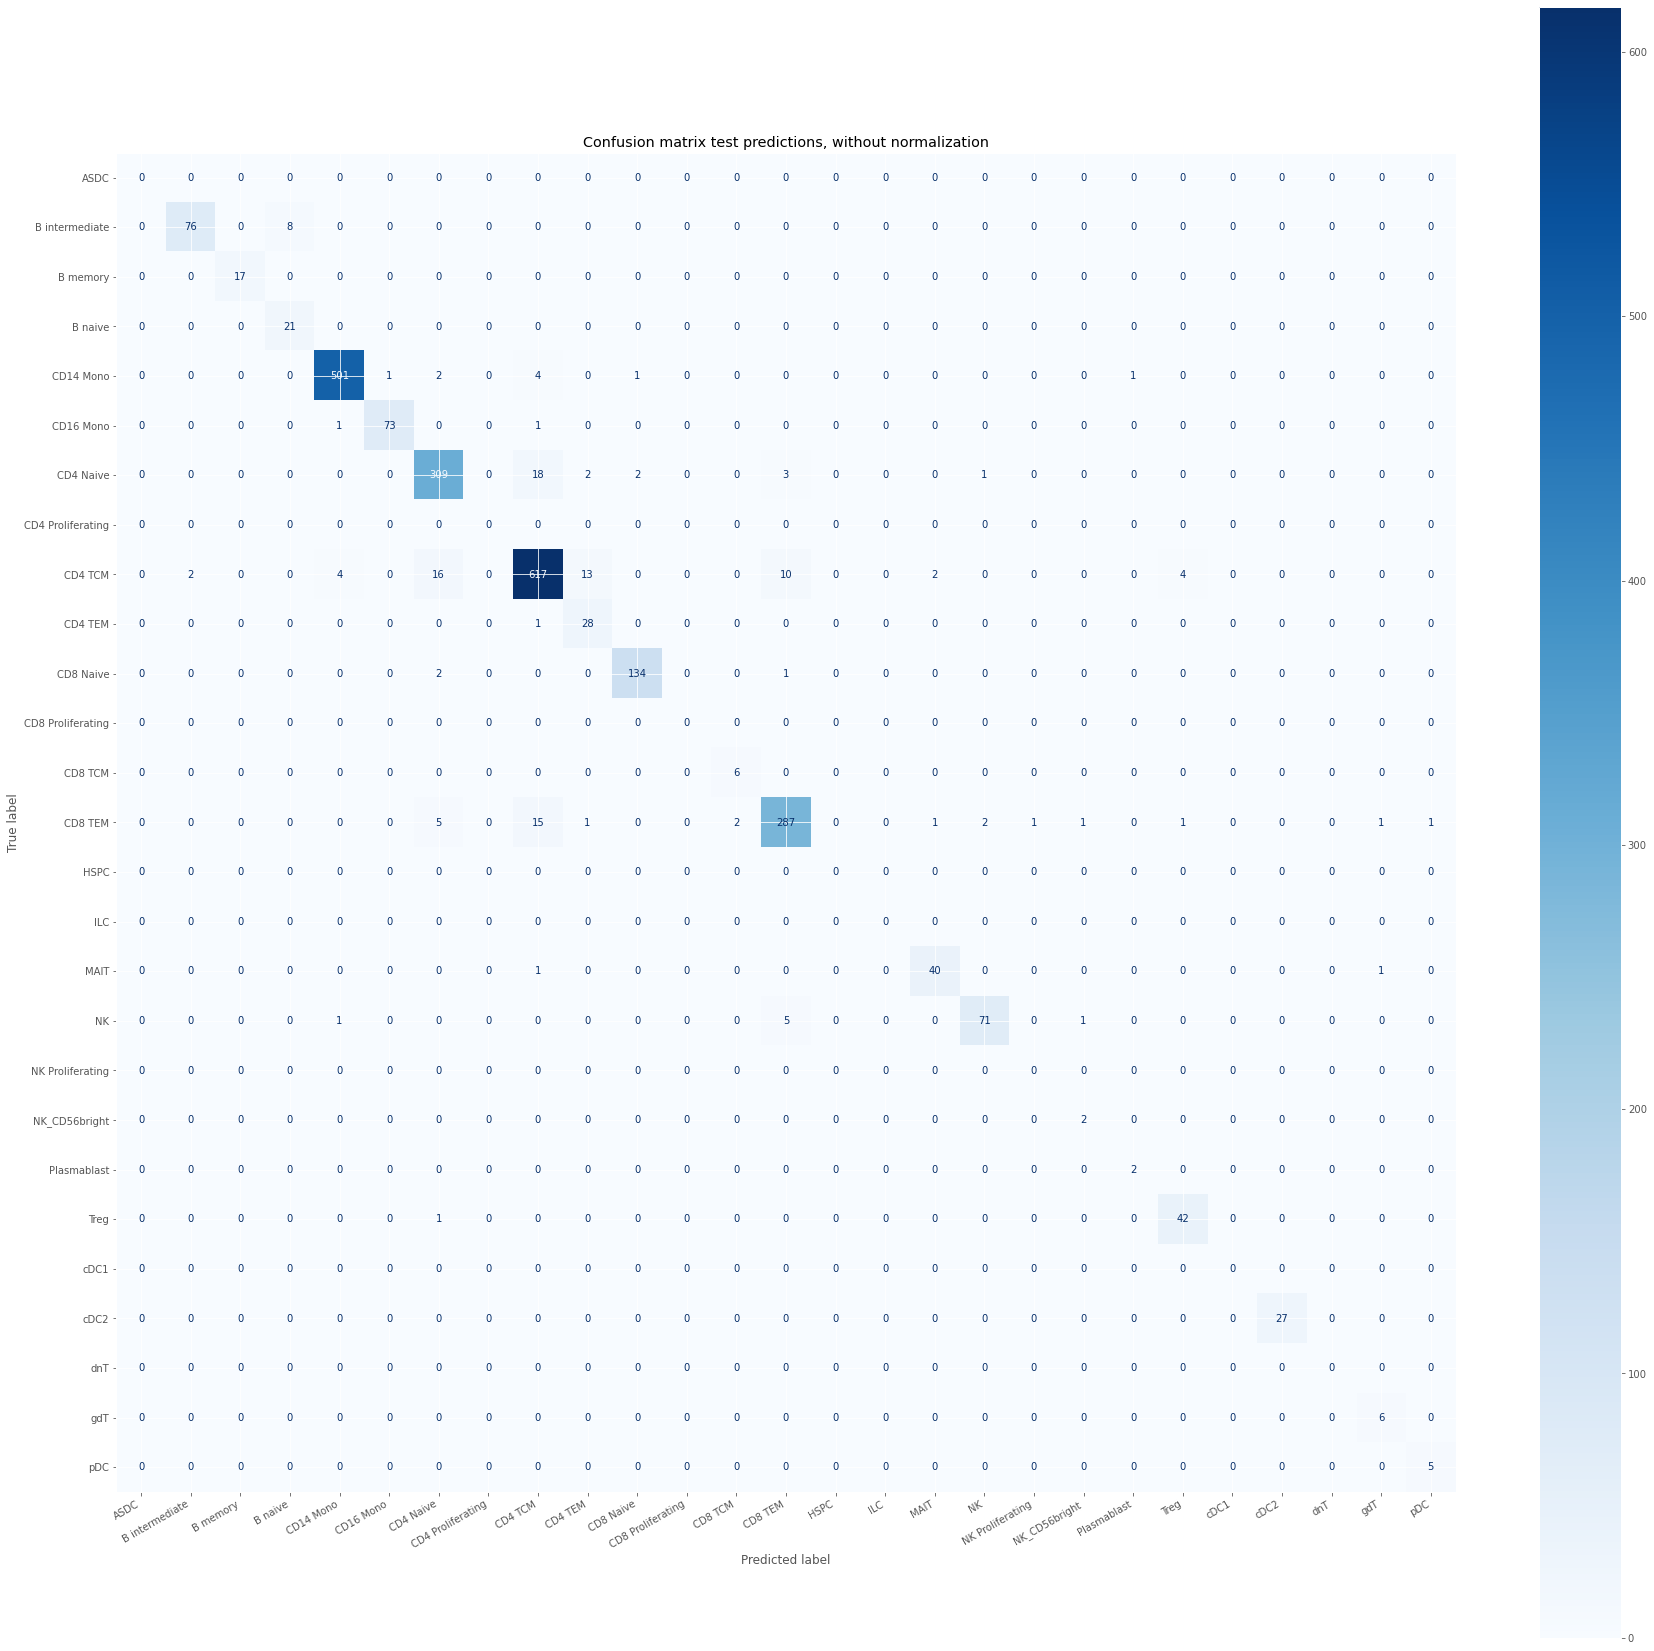

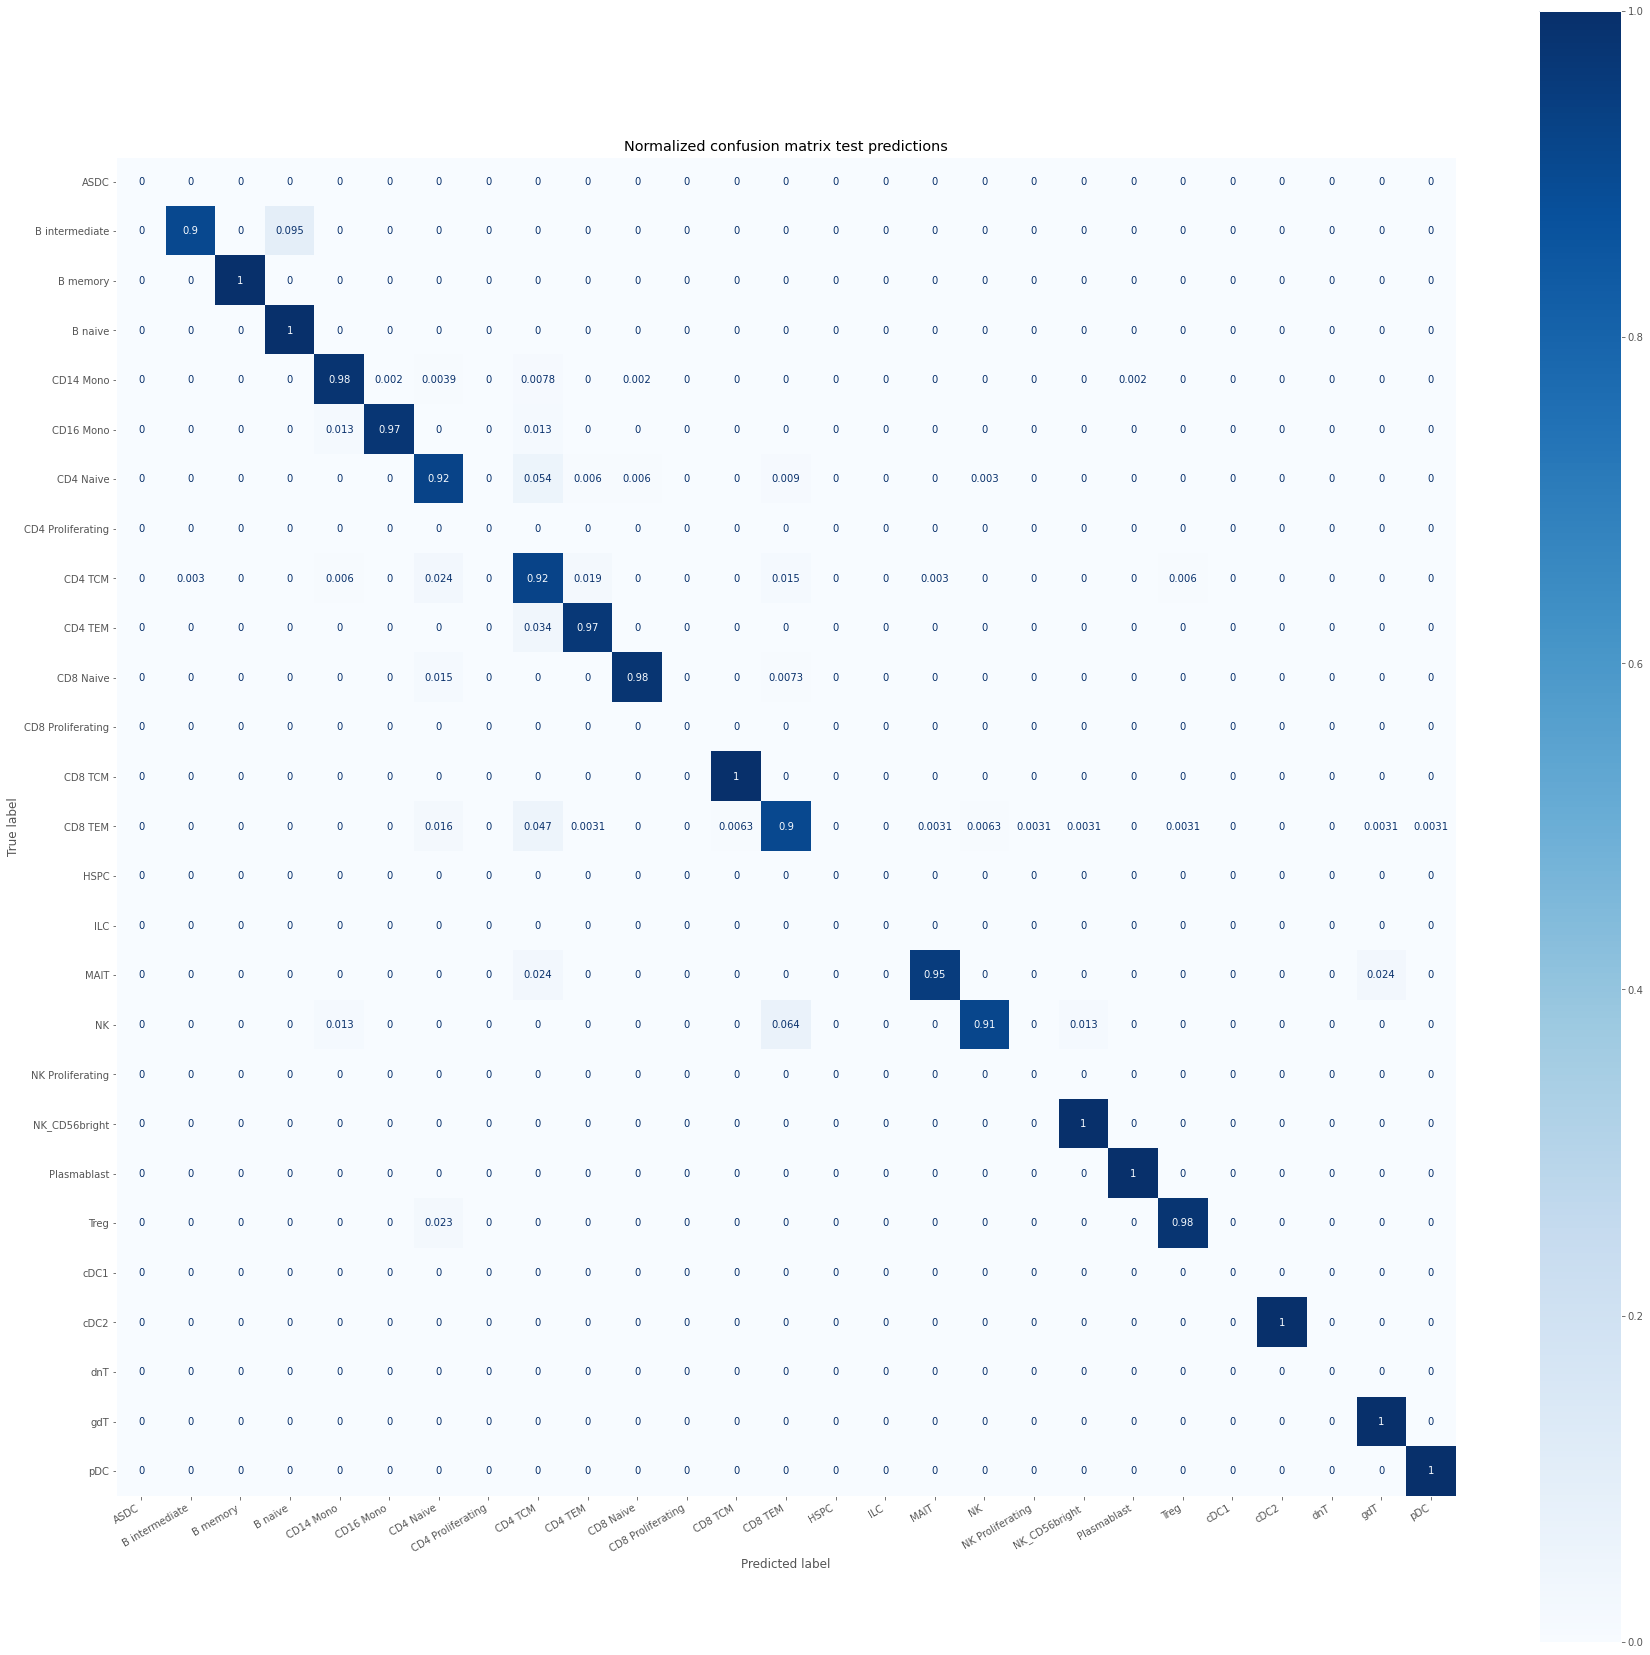

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix test predictions, without normalization", None, test_pred, Y_test, cell_types),
    ("Normalized confusion matrix test predictions", "true", test_pred, Y_test, cell_types),
]
plt.rcParams['figure.figsize'] = [30, 30]
for title, normalize, pred, labels, celltypes in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        pred,
        labels,
        cmap=plt.cm.Blues,
        normalize=normalize,
        labels=celltypes
    )
    plt.xticks(rotation=30, ha='right')
    disp.ax_.set_title(title)

plt.grid(False)
plt.show()

In [58]:
PBMC.obsm

AxisArrays with keys: X_umap.atac, X_umap.rna

## Umaps

In [59]:
umap_coordinates_train = PBMC.obsm['X_umap.atac']
umap_coordinates_test = PBMC.obsm['X_umap.atac']

def show_umap(_celltypes, _umapcoords, labels, title='UMAP Plot observations', s=10):
    colors = plt.cm.get_cmap('viridis', len(_celltypes))

    for i, ct_ in enumerate(_celltypes):
        mask = (labels == ct_)
        plt.scatter(_umapcoords[mask, 0], _umapcoords[mask, 1], label=ct_, color=colors(i), s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title)
    plt.legend(title='Cell Type')
    return plt.show()

def show_predictions_umap(_umapcoords, _predictions, _labels, _celltypes, _maincelltypes=False, title='UMAP Plot prediction accuracy', s=10):
    RightPred_mask = (_predictions == _labels)
    plt.scatter(_umapcoords[RightPred_mask, 0], _umapcoords[RightPred_mask, 1], label="Right Prediction", color='green', s=s)
    
    if _maincelltypes:
        MainCellTypePred_mask = np.logical_and((to_main_cell_types(_predictions) == to_main_cell_types(_labels)), np.invert(RightPred_mask))
        plt.scatter(_umapcoords[MainCellTypePred_mask, 0], _umapcoords[MainCellTypePred_mask, 1], label="Right Main Cell Type Prediction", color='blue', s=s)
    
    WrongPred_Mask = np.invert(np.logical_or(RightPred_mask, MainCellTypePred_mask) if _maincelltypes else RightPred_mask)
    plt.scatter(_umapcoords[WrongPred_Mask, 0], _umapcoords[WrongPred_Mask, 1], label="Wrong Prediction", color='red', s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title, fontsize=30)
    l = plt.legend(title='Cell Type', fontsize=30, title_fontsize=40)
    for legendHandle in l.legendHandles:
        legendHandle._sizes = [300]
    plt.show()

In [60]:
show_umap(cell_types_sorted, BMMC.obsm['ATAC_umap'], BMMC.obs['cell_type'], title="UMAP plot all data with cell subtypes")
show_umap(main_cell_types_sorted, BMMC.obsm['ATAC_umap'], to_main_cell_types(BMMC.obs['cell_type']), title="UMAP plot all data with main cell types")

NameError: name 'cell_types_sorted' is not defined

In [ ]:
show_umap(cell_types_sorted, umap_coordinates_test, Y_test, title="UMAP plot test data with cell subtypes")
show_umap(main_cell_types_sorted, umap_coordinates_test, Y_test_main, title="UMAP plot test data with main celltypes")

In [ ]:
show_predictions_umap(umap_coordinates_test, test_pred, Y_test, cell_types_sorted, _maincelltypes=False, title='UMAP Plot prediction accuracy with subtypes', s=10)
show_predictions_umap(umap_coordinates_test, test_pred, Y_test, cell_types_sorted, _maincelltypes=True, title='UMAP Plot prediction accuracy with main celltypes', s=10)

In [ ]:
for d in donors:
    _dfilter = BMMC.obs['DonorID'] == d
    show_predictions_umap(BMMC.obsm['ATAC_umap'][_dfilter], all_pred[_dfilter], BMMC.obs['cell_type'][_dfilter], cell_types_sorted, _maincelltypes=True, title=f'UMAP Plot prediction accuracy {"test" if d in test_donors_idx else "train"} donor {d}', s=15)